In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
labels = pd.read_csv("../input/rsna-heart-detection/rsna_heart_detection.csv")
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [3]:
labels.shape

(496, 8)

In [4]:
ROOT_PATH = Path("../input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("../Processed-Heart-Detection")

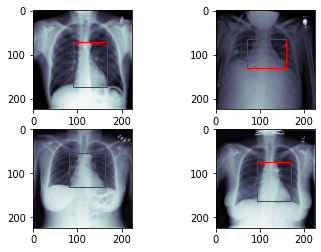

In [5]:
fig, axis = plt.subplots(2 ,2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data["name"]
        dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm file
        dcm_path =dcm_path.with_suffix(".dcm")
        
        dcm = pydicom.read_file(dcm_path)
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224,224))
        
        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]
        
        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x,y), width, height, linewidth=1, edgecolor="r", facecolor="none")
        axis[i][j].add_patch(rect)
        c+=1

We use a similar preprocessing routine to the one used for the classification task.

To be able to distinguish between train and validation subjects, we store them in two lists and later save these lists.

In [6]:
sums = 0
sums_squared = 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):
    dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
    
    dcm = pydicom.read_file(dcm_path)  # Read the dicom file with pydicom
    
    # Retrieve the actual image 
    dcm_array = dcm.pixel_array
        
    # Resize the image to drastically improve training speed
    # In order to reduce the space when storing the image we convert it to float16
    # Standardize to 0-1 range
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 255).astype(np.float16)
          
    # 4/5 train split, 1/5 val split
    train_or_val = "train" if counter < 400 else "val" 
    
    # Add to corresponding train or validation patient index list
    if train_or_val =="train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)
        
    current_save_path = SAVE_PATH/train_or_val # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    
    np.save(current_save_path/patient_id, dcm_array) # Save the array in the corresponding directory
    
    normalizer = 224*224
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array**2).sum() / normalizer

In [7]:
np.save("../Processed-Heart-Detection/train_subjects", train_ids)
np.save("../Processed-Heart-Detection/val_subjects", val_ids)

In [8]:
mean = sums /len(train_ids)
std = np.sqrt((sums_squared / len(train_ids)) - mean**2)
mean, std

(0.49430165816326493, 0.2527964897943661)

In [9]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug   #imgaug to set a random seed for augmentations
from imgaug.augmentables.bbs import BoundingBox 
# BoundingBox from imgaug to automatically handle the coordinates when augmenting the image

In [10]:
class CardiacDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
        
    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)
    
    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        
        patient = self.patients[idx]
        
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]
        
        # Get entries of given patient
        # Extract coordinates
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()
        y_max = y_min + data["h"].item()
        bbox = [x_min, y_min, x_max, y_max]
        
        # Load file and convert to float32
        file_path = self.root_path/patient  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            random_seed = torch.randint(0, 100000, (1,)).item()
            imgaug.seed(random_seed)
            
            img, aug_bbox = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
            
        # Normalize the image according to the values computed in Preprocessing    
        img = (img - 0.494) / 0.252
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        return img, bbox

In [11]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [12]:
# First create the augmentation object (augmentation pipeline define)
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10, 10))
])

In [13]:
labels_path = "../input/rsna-heart-detection/rsna_heart_detection.csv"
patients_path = "../Processed-Heart-Detection/train_subjects.npy"
train_root = "../Processed-Heart-Detection/train/"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

In [14]:
dataset[0]

(tensor([[[-1.9603, -1.9603, -1.9603,  ..., -1.9506, -1.9515, -1.9539],
          [-1.9603, -1.9603, -1.9603,  ..., -1.9140, -1.9128, -1.9181],
          [-1.9603, -1.9603, -1.9603,  ..., -1.6829, -1.7486, -1.7995],
          ...,
          [-1.9603, -1.9603, -1.9603,  ...,  0.5242,  0.5693,  0.5279],
          [-1.9603, -1.9603, -1.9603,  ...,  0.4491,  0.4318,  0.4448],
          [-1.9603, -1.9603, -1.9603,  ...,  0.5064,  0.5023,  0.4088]]]),
 tensor([ 90.2850,  65.5686, 192.0372, 191.6965]))

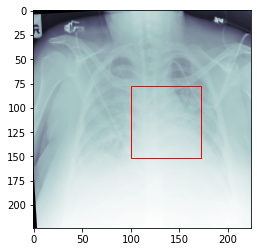

In [15]:
img, bbox = dataset[48]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

# run this cell more than one. every run correctly sign the heart

tensor([ 89.2425,  69.5636, 149.5885, 132.5878])


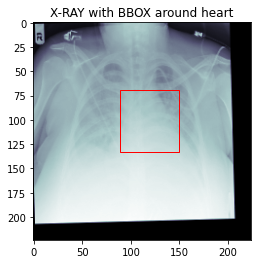

In [16]:
img, label = dataset[48]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
spot1 = patches.Rectangle((label[0], label[1]), label[2] - label[0], label[3] - label[1], edgecolor='r', facecolor='none')
axis.add_patch(spot1)

axis.set_title("X-RAY with BBOX around heart")
print(label)

In [17]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/dataset/dataset_.py", dst = "../working/dataset_.py") 

'../working/dataset_.py'

In [18]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa
from dataset_ import CardiacDataset # IMPORT THE DATASET

In [19]:
train_root_path = "../Processed-Heart-Detection/train"
train_subjects = "../Processed-Heart-Detection/train_subjects.npy"
val_root_path = "../Processed-Heart-Detection/val"
val_subjects = "../Processed-Heart-Detection/val_subjects.npy"

train_transformers = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale=(0.8, 1.2),
        rotate=(-10, 10),
        translate_px=(-10, 10))
])

In [20]:
train_dataset = CardiacDataset("../input/rsna-heart-detection/rsna_heart_detection.csv", train_subjects, train_root_path, train_transformers)
val_dataset = CardiacDataset("../input/rsna-heart-detection/rsna_heart_detection.csv", val_subjects, val_root_path, None)

In [21]:
batch_size = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [22]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Model Creation

4 outputs: Instead of predicting a binary label we need to estimate the location of the heart (xmin, ymin, xmax, ymax).

Loss function: Mean Squared Error as we are dealing with continuous values.

In [23]:
class CardiacDetectionModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)  #transfer learning
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 ==0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        
        if batch_idx % 50 ==0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            img = ((x_ray[i] * 0.252) + 0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [24]:
# Create the model object
model = CardiacDetectionModel()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [25]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val Loss",
    save_top_k=10,
    mode="min"    
)

In [26]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training
#trainer = pl.Trainer(logger=TensorBoardLogger("./logs"), log_every_n_steps=1, callbacks=checkpoint_callback, max_epochs=10)

gpus = 1 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger("./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=100)

In [27]:
trainer.fit(model, train_loader, val_loader)

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.load_from_checkpoint("logs/default/version_0/checkpoints/epoch=99-step=4999.ckpt")
model.eval();
model.to(device);

In [30]:
preds = []
labels =[]

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds=torch.stack(preds)
labels=torch.stack(labels)

In [31]:
preds

tensor([[ 93.5021,  64.0223, 158.8010, 154.0735],
        [ 89.0242,  48.7221, 169.4451, 130.4690],
        [ 82.2277,  71.6492, 167.9649, 175.7497],
        [ 93.0517,  64.1570, 170.6482, 169.7157],
        [ 81.4314,  60.7733, 156.5653, 150.8711],
        [ 79.8621,  71.3982, 171.7099, 180.3393],
        [ 82.3326,  68.2175, 168.6414, 173.6718],
        [ 80.4313,  33.7107, 166.9049, 130.0764],
        [ 96.2805,  58.3160, 172.8220, 154.1503],
        [ 96.0602,  55.5277, 190.2647, 146.2607],
        [ 96.9494,  57.2591, 180.6821, 160.9265],
        [ 91.7663,  69.3892, 196.4318, 178.7130],
        [ 92.2473,  67.3611, 173.8814, 148.4679],
        [ 91.9562,  60.8631, 161.2921, 167.9677],
        [ 89.9178,  56.4145, 178.1309, 148.4128],
        [ 90.1111,  55.6332, 168.9016, 128.6523],
        [107.2067,  72.0857, 177.6143, 166.8203],
        [ 89.0626,  56.9828, 182.5164, 157.7875],
        [ 95.5099,  84.5717, 171.4804, 185.1882],
        [ 89.8939,  66.9952, 190.9637, 177.7724],


In [43]:
labels

tensor([[ 96,  66, 166, 154],
        [ 91,  57, 167, 137],
        [ 84,  75, 167, 170],
        [ 94,  70, 171, 176],
        [ 81,  63, 154, 150],
        [ 83,  77, 171, 181],
        [ 86,  69, 160, 156],
        [ 95,  47, 164, 137],
        [ 94,  59, 174, 148],
        [ 98,  52, 185, 144],
        [ 93,  54, 178, 158],
        [ 92,  63, 194, 179],
        [ 94,  71, 176, 146],
        [ 91,  52, 157, 172],
        [ 89,  54, 172, 151],
        [ 89,  59, 162, 128],
        [109,  65, 180, 172],
        [ 91,  62, 180, 161],
        [ 98,  77, 171, 184],
        [ 90,  69, 185, 182],
        [ 97,  60, 176, 149],
        [101,  49, 196, 148],
        [ 94,  49, 166, 176],
        [ 99,  45, 166, 121],
        [ 88,  67, 152, 151],
        [ 47,  89, 141, 154],
        [ 75,  65, 160, 179],
        [ 79,  84, 165, 181],
        [ 96,  44, 192, 161],
        [ 76,  85, 174, 187],
        [ 83,  64, 153, 164],
        [ 91,  51, 166, 142],
        [ 73,  70, 152, 146],
        [ 

In [44]:
labels.shape

torch.Size([96, 4])

In [41]:
abs(preds-labels).mean(0) # --> 5/224

tensor([3.2033, 4.2960, 3.9110, 4.5083])

In [40]:
abs(preds-labels).mean(0).sum() / 4 / 224 * 100

tensor(1.7766)

tensor([ 79,  75, 161, 171])


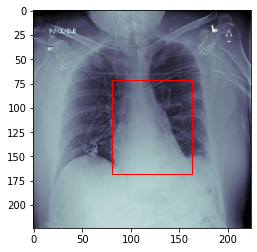

In [45]:
IDX = 50  # Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)

In [38]:
preds[50]

tensor([ 80.2740,  71.0216, 162.8350, 167.8594])